### Base settings

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from ood_with_vit.visualizer.feature_extractor import FeatureExtractor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [3]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name / summary
checkpoint_path = log_root / 'checkpoints'

In [4]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

def initialize_vit_model(config, finetuned: bool = True, verbose: int = 0):
    assert config.model.pretrained, 'only pretrained models are allowed'
    if config.model.pretrained:
        if finetuned:
            print('init finetuned model')
            n_class = config.dataset.n_class
            model = torch.hub.load(
                repo_or_dir=config.model.repo,
                model=config.model.pretrained_model,
                pretrained=False,
            )
            model.head = nn.Linear(model.head.in_features, n_class)
        else:
            print('init pretrained-only model')
            model = torch.hub.load(
                repo_or_dir=config.model.repo,
                model=config.model.pretrained_model,
                pretrained=True,
            )
    model = model.to(device=device)
    if verbose:
        print(model)
        
    if finetuned:
        checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

        state_dict = checkpoint['model_state_dict']
        trimmed_keys = []
        for key in state_dict.keys():
            # remove prefix 'module.' for each key (in case of DataParallel)
            trimmed_keys.append(key[7:])
        trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

        model.load_state_dict(trimmed_state_dict)
    return model

In [5]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, Dataset

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

id_dataset = CIFAR10(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
id_test_dataloader = DataLoader(
    dataset=id_dataset, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)
id_dataset_name = 'cifar10'

ood_dataset = CIFAR100(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
ood_test_dataloader = DataLoader(
    dataset=ood_dataset, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)
ood_dataset_name = 'cifar100'

print(id_dataset.class_to_idx)
print(ood_dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, '

### Utility

In [6]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed = 1234

### OOD detection baselines

In [7]:
from ood_with_vit.utils import compute_ood_scores
from ood_with_vit.utils.ood_metrics import auroc, aupr, fpr_at_95_tpr
from ood_with_vit.utils.visualization import plot_roc_curve, plot_precision_recall_curve

### OOD detection by Mahalanobis

In [15]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config, finetuned=False)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
feature_extractor.hook()
mahalanobis = Mahalanobis(config, model, id_train_dataloader, feature_extractor)

init pretrained-only model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:23<00:00,  4.16it/s]


covairance norms: [35.333, 56.15467, 24.710087, 24.760406, 39.9555, 33.052032, 34.579536, 37.751755, 43.906643, 69.12952]
covariance norm: 20.314365237275208


In [16]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:05<00:00, 18.02it/s]

id mean score: 185.77121 id variance: 5098.766
ood mean score: 296.2357 ood variance: 13700.672


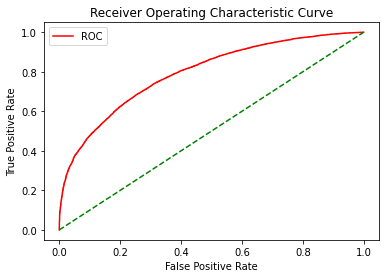

Mahalanobis AUROC score: 0.793445925


In [17]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

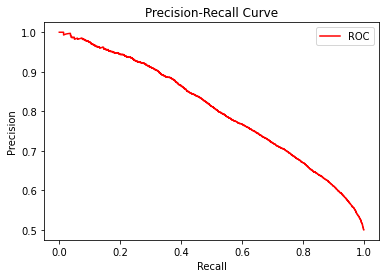

Mahalanobis AUPR score: 0.8042694946122347


In [18]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [19]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.7116


#### OOD detection by DMD

In [24]:
from ood_with_vit.metrics.dmd import DMD

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config, finetuned=False)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
feature_extractor.hook()
dmd = DMD(
    config=config, 
    model=model,
    id_dataloader=id_train_dataloader,
    feature_extractor=feature_extractor,
)

init pretrained-only model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:22<00:00,  4.45it/s]


covariance norm: 20.314365237275208
name: patch_embed.norm


In [25]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=dmd,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


processing out-of-distribution samples...


100%|██████████| 100/100 [01:45<00:00,  1.06s/it]

id mean score: -0.03479890251159668 id variance: 5830.727610209005
ood mean score: 77.69446574096679 ood variance: 11837.016220215226


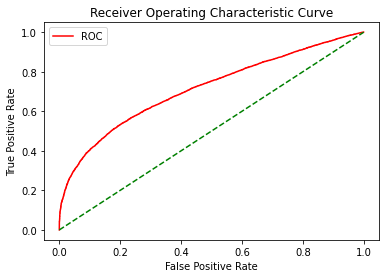

DCL AUROC score: 0.7138753699999999


In [26]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('DMD AUROC score:', auroc_score)

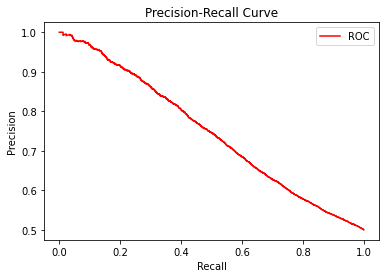

DMD AUPR score: 0.7471540902729743


In [27]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('DMD AUPR score:', aupr_score)

In [28]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('DML fpr95 score:', fpr95)

DML fpr95 score: 0.8764
